# Implementation of a new rPPG method

## Part 2 : Notebook for the prediction of the 3D-CNN model

This jupyter notebook file complements the "Train_3DCNN_model_BPM.ipynb" file. In this file, we can test the model predictions on real videos and highlight logic of the future implementation into the pyVHR framework. ([Link](https://ieeexplore.ieee.org/document/9272290)) ([GitHub](https://github.com/phuselab/pyVHR))

This file is based on the implementation described in the following article :
Frédéric Bousefsaf, Alain Pruski, Choubeila Maaoui, 3D convolutional neural networks for remote pulse rate measurement and mapping from facial video, Applied Sciences, vol. 9, n° 20, 4364 (2019). ([Link](https://www.mdpi.com/2076-3417/9/20/4364)) ([GitHub](https://github.com/frederic-bousefsaf/ippg-3dcnn))

## Import of libraries

Previously , you have to install theses python librairies :
* tensorflow
* matplotlib
* scipy
* numpy
* opencv-python
* Copy

In [1]:
import os
#RUN ON CPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

#Tensorflow/KERAS
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.models import model_from_json
from tensorflow.python.keras.utils import np_utils

# Numpy / Matplotlib / OpenCV / Scipy / Copy
import numpy as np
import scipy.io
import scipy.stats as sp
import matplotlib.pyplot as plt
import cv2
from copy import copy

## Load video


In the pyVHR framework, we work on a processed video. The processing consists of detecting and extracting an area of interest, in order to apply our rPPGs methods on relevant data.

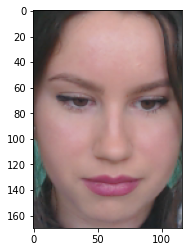

In [2]:
# Load pre-processed video
filenamez = './data_test/croppedFaces.npz'

# Information about this video
data = np.load(filenamez, allow_pickle=True)
faces = data['a']
numFrames = int(data['b'])
frameRate = int(data['c'])
height = int(data['d'])
width = int(data['e'])
duration = float(data['f'])
codec = data['g']
detector = data['h']
extractor = data['i']
cropSize = faces[0].shape

#Print first frame
plt.imshow(faces[0])

## Load model and information

In [3]:
# Features of Frames
IMAGE_HEIGHT = cropSize[0]
IMAGE_WIDTH = cropSize[1]

if (cropSize[2]<3):
    IMAGE_CHANNELS = 1
else:
    IMAGE_CHANNELS = cropSize[2]

# Load model
RESULTS_PATH = "./model"
model = model_from_json(open(f'{RESULTS_PATH}/model_conv3D.json').read())
model.load_weights(f'{RESULTS_PATH}/weights_conv3D.h5')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# define the frequencies // output dimension (number of classes used during training)
freq_BPM = np.linspace(55, 240, num=model.output_shape[1]-1)
freq_BPM = np.append(freq_BPM, -1)     # noise class

# define patch size and number of images per video (directly from the model information)
NB_SELECTED_IMAGES_PER_VIDEO = model.input_shape[1]
PATCH_WIDTH = model.input_shape[2]
PATCH_HEIGHT = model.input_shape[3]

## Loading video

In [4]:
# 2. LOAD DATA
imgs = np.zeros(shape=(NB_SELECTED_IMAGES_PER_VIDEO, IMAGE_HEIGHT, IMAGE_WIDTH, 1))

# load images (imgs contains the whole video)
for j in range(NB_SELECTED_IMAGES_PER_VIDEO):

    if (IMAGE_CHANNELS==3):
        temp = faces[j]/255
        temp = temp[:,:,1]      # only the G component is currently used
    else:
        temp = faces[j] / 255

    imgs[j] = np.expand_dims(temp, 2)

## Formating Video and Prediction

In [10]:
xtest = np.zeros(shape=(NB_SELECTED_IMAGES_PER_VIDEO, PATCH_WIDTH , PATCH_HEIGHT, 1))
for j in range(0,NB_SELECTED_IMAGES_PER_VIDEO):
    faceCopy = copy(imgs[j])
    np.random.shuffle(faceCopy)
    for m in range(0, PATCH_WIDTH):
        for n in range(0, PATCH_HEIGHT):
            xtest[j][m][n]= faceCopy[m][n]
            
            
h = model.predict(np.expand_dims(xtest, 0))

def idxMax(list):
    idx =0
    maxi =0
    for i in range(0, len(list)):
        if maxi < list[i]:
            idx = i
            maxi = list[i]
    return idx

print('BPM frequency estimated = ' + str(freq_BPM[idxMax(h[0])]))

BPM frequency estimated = 122.5
